In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import sys
import seaborn as sns
from scipy.special import comb
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.colors import LogNorm
import matplotlib as mpl
import pandas as pd
import itertools as it

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return it.chain.from_iterable(it.combinations(s, r) for r in range(len(s)+1))

mpl.rc_file_defaults()
plt.rcParams.update({'font.size': 7})
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2

In [2]:
# set some things
num_mutations_H1 = 15
order_H1 = 4
num_term_list_H1 = np.array([int(comb(num_mutations_H1,i)) for i in range(1,order_H1+1)])
total_params_H1 = sum(num_term_list_H1)
order_start_indices_H1 = list(np.cumsum(num_term_list_H1)+1)
order_start_indices_H1.insert(0,1)
print(num_term_list_H1,total_params_H1)
print(order_start_indices_H1)


mut_names = ['339','371','373','375','417','440','446','477','478','484','493','496','498','501','505']

H1_color = '#e8735c'

ep_type = 'biochem'

[  15  105  455 1365] 1940
[1, 16, 121, 576, 1941]


# H1

In [3]:
# read model coefficients


coefs_H1 = np.zeros(total_params_H1+1)
names_H1 = []
sig_H1 = np.full((total_params_H1+1),0)
stderr_H1 = np.zeros(total_params_H1+1)
cis_H1 = np.zeros((total_params_H1+1,2))

with open('ACE2_4order_biochem.txt','r') as readfile:
    coef_reader = csv.reader(readfile,delimiter='\t')
    num_params = int(next(coef_reader)[-1])
    r2_train = float(next(coef_reader)[-1])
    header = next(coef_reader)
    print(header)
    for i in range(total_params_H1+1):
        row = next(coef_reader)
        names_H1.append(row[0])
        coefs_H1[i] = float(row[1])  
        if i >= 1:
            stderr_H1[i] = float(row[2])
            cis_H1[i,0] = float(row[4])
            cis_H1[i,1] = float(row[5])
            if float(row[4])*float(row[5]) > 0:
                sig_H1[i] = 1
    readfile.close()
            
print(len(coefs_H1))      

['Term', 'Coefficient', 'Standard Error', 'p-value', '95% CI lower', '95% CI upper']
1941


## Figure 3A

0.0 3.7382978325507445


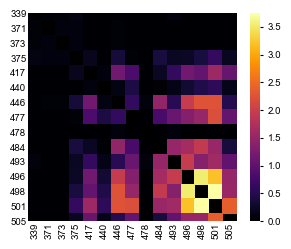

In [5]:

# initialize matrices to store values

# total (lower diagonal)
total_epistasis = np.zeros((15,15),dtype=float)
for i in range(15):  
    total_epistasis[i,i] = np.nan


# add up all coefficients
for i in range(1,len(coefs_H1)):

    muts_involved = [int(x)-1 for x in names_H1[i].split(',')]
    
    # only consider 3rd order and higher
    if len(muts_involved) >= 3:
        # only consider significant terms
        if sig_H1[i]:
            for j in range(len(muts_involved)):
                for k in range(j+1,len(muts_involved)):
                    total_epistasis[muts_involved[k],muts_involved[j]] += np.abs(coefs_H1[i])
                    total_epistasis[muts_involved[j],muts_involved[k]] += np.abs(coefs_H1[i])


print(np.nanmin(total_epistasis),np.nanmax(total_epistasis))
min_val = np.nanmin(total_epistasis)

    
sns.set_style({"axes.facecolor": "k"})       
plt.figure(figsize=(3,2.5))
sns.heatmap(total_epistasis,cmap='inferno',cbar_kws={"pad": 0.05}) #,vmin=0.0,vmax=np.nanmax(total_epistasis)) 
plt.xticks(np.arange(0.5,num_mutations_H1+0.5,1),mut_names,rotation='90')
plt.yticks(np.arange(0.5,num_mutations_H1+0.5,1),mut_names,rotation='0')
plt.tick_params(length=0,pad=1)


plt.tight_layout()
plt.savefig('images/RBD_ACE2_biochem_3andup_total.pdf')
plt.show()


## Figure 3F

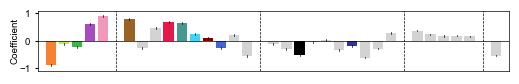

In [43]:
# 

sns.set_style({"axes.facecolor": "w"})       

colordict = {'red':'#e6194B', 'green':'#3cb44b', 'yellow':'#ffe119', 'blue':'#4363d8', 
             'orange':'#f58231', 'cyan':'#42d4f4', 'magenta':'#f032e6', 'pink':'#fabed4', 
             'teal':'#469990', 'lavender':'#dcbeff', 'brown':'#9A6324', 'beige':'#fffac8', 
             'maroon':'#800000', 'mint':'#aaffc3', 'navy':'#000075', 'black':'#000000','white':'#ffffff',
             'olive':'#808000','lime':'#bfef45','purple':'#911eb4',
            'darkbeige':'#ccc8a0','lightyellow':'#ffea5e','lightnavy':'#333399','lightpurple':'#a74bc3',
            'lightmagenta':'#f35beb','darkpink':'#f299b9','grey':'lightgrey'}


muts_to_consider = [1,4,6,9,10]

coefs = {}

for s in powerset(muts_to_consider):
    if len(s) >= 1: 
        name = ','.join([str(x) for x in s])
        coefs[name] = [coefs_H1[names_H1.index(name)],stderr_H1[names_H1.index(name)]]

palette_dict = {'4':'lime','6':'green','9':'lightpurple','4,6':'teal','4,9':'cyan','6,9':'blue','4,6,9':'lightnavy',
                '1':'orange','10':'darkpink','1,4':'brown','1,10':'red','4,10':'maroon','1,4,10':'black'}


order_1 = ['1','4','6','9','10',
           '1,4','1,6','1,9','1,10','4,6','4,9','4,10','6,9','6,10','9,10']
palette_1 = [colordict[palette_dict[x]] if x in palette_dict.keys() else colordict['grey'] for x in order_1]
           
order_2 = ['1,4,6','1,4,9','1,4,10','1,6,9','1,6,10','1,9,10','4,6,9','4,6,10','4,9,10','6,9,10',
          '1,4,6,9','1,4,6,10','1,4,9,10','1,6,9,10','4,6,9,10',
          '1,4,6,9,10']
palette_2 = [colordict[palette_dict[x]] if x in palette_dict.keys() else colordict['grey'] for x in order_2]

name_order_1 = []
for i in range(len(order_1)):
    muts = order_1[i].split(',')
    names = [mut_names[int(x)-1] for x in muts]
    #print(muts,names)
    name_string = ','.join(names)
    name_order_1.append(name_string)

name_order_2 = []
for i in range(len(order_2)):
    muts = order_2[i].split(',')
    names = [mut_names[int(x)-1] for x in muts]
    #print(muts,names)
    name_string = ','.join(names)
    name_order_2.append(name_string)




xvals = [0,1,2,3,4,6,7,8,9,10,11,12,13,14,15,16] #np.arange(len(order_1))
xvals2 = np.array([0,1,2,3,4,5,6,7,8,9,11,12,13,14,15,17])+17 #np.arange(len(order_2))

width = 0.25

plt.rcParams.update({'font.size': 7})    

plt.figure(figsize=(5.2,0.85))

ax = plt.subplot(111)
for i in range(len(order_1)):
    plt.bar(xvals[i],coefs[order_1[i]][0],zorder=1,color=palette_1[i])
    plt.plot([xvals[i],xvals[i]],
             [coefs[order_1[i]][0]-coefs[order_1[i]][1],coefs[order_1[i]][0]+coefs[order_1[i]][1]],'k-',zorder=10,linewidth=0.5)

plt.xticks([])
plt.ylim([-1.1,1.1])

for i in range(len(order_2)):
    plt.bar(xvals2[i],coefs[order_2[i]][0],zorder=1,color=palette_2[i])
    plt.plot([xvals2[i],xvals2[i]],
             [coefs[order_2[i]][0]-coefs[order_2[i]][1],coefs[order_2[i]][0]+coefs[order_2[i]][1]],'k-',zorder=10,linewidth=0.5)

plt.xticks([])
plt.ylabel('Coefficient',labelpad=0)
plt.xlim([-1,35])

for i in [5,16,27,33]:
    plt.plot([i,i],[-1.5,1.5],'k--',linewidth=0.5)

plt.plot([-1,35],[0,0],'k-',linewidth=0.5)


plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.savefig('images/coefs_all.pdf')
plt.show()
